In [1]:
import warnings
import itertools
import numpy as np 
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss

warnings.simplefilter(action='ignore')
sns.set_style('whitegrid')

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc # We're gonna be clearing memory a lot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

p = sns.color_palette()
plt.style.use("fivethirtyeight")

print('# File sizes')
for f in os.listdir('./'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('./' + f) / 1000000, 2)) + 'MB')
        
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# File sizes
aviation_notebook_1.ipynb     0.01MB
test.csv                      4786.27MB
aviation                      0.0MB
train.csv                     1234.76MB
.ipynb_checkpoints            0.0MB
sample_submission.csv         294.3MB


In [3]:
%%time
train  = reduce_mem_usage(pd.read_csv("./train.csv", encoding='utf-8'))
gc.collect()

Mem. usage decreased to 306.37 Mb (70.5% reduction)
CPU times: user 39.4 s, sys: 5.42 s, total: 44.8 s
Wall time: 45.5 s


In [4]:
%%time
test  = reduce_mem_usage(pd.read_csv("./test.csv"))
gc.collect()

Mem. usage decreased to 1062.24 Mb (72.3% reduction)
CPU times: user 2min 29s, sys: 30.9 s, total: 3min
Wall time: 3min 4s


In [5]:
train.head(5)

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,...,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,1,CA,0.011719,1,-5.285156,26.781250,-9.523438,-12.796875,16.718750,33.75000,...,37.375000,17.437500,19.203125,20.593750,-3.951172,14.507812,-4520.0,817.5,388.75,A
1,1,CA,0.015625,1,-2.427734,28.437500,-9.320312,-3.757812,15.968750,30.43750,...,31.171875,19.406250,19.687500,21.359375,1.332031,17.750000,-4520.0,817.5,388.75,A
2,1,CA,0.019531,1,10.671875,30.421875,15.351562,24.718750,16.140625,32.15625,...,-12.015625,19.390625,23.171875,22.406250,1.538086,22.250000,-4520.0,817.5,388.75,A
3,1,CA,0.023438,1,11.453125,25.609375,2.433594,12.414062,20.531250,31.50000,...,18.578125,23.156250,22.640625,19.343750,2.544922,19.000000,-4520.0,817.5,388.75,A
4,1,CA,0.027344,1,7.285156,25.937500,0.113586,5.746094,19.828125,28.75000,...,6.554688,22.750000,22.671875,20.296875,1.699219,22.812500,-4520.0,817.5,388.75,A


experiment,CA,DA,SS
event,,,
A,5690,1423064,1420055
B,0,0,130597
C,1652686,0,0
D,0,235329,0


Text(0.5,1,'Number of Congnitive Biases per event')

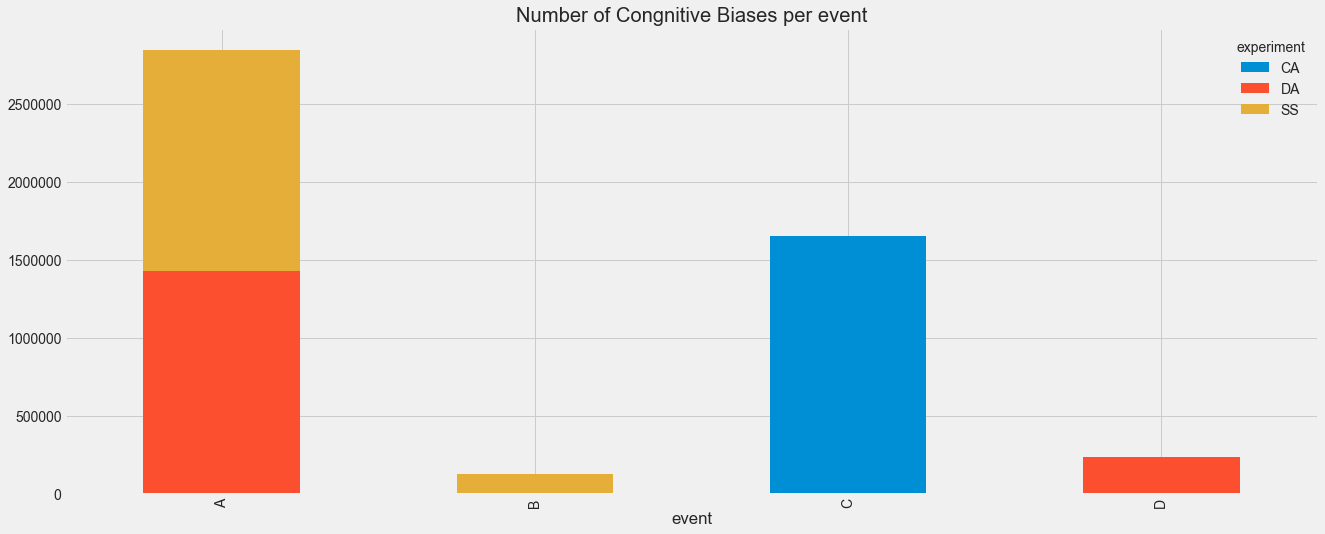

In [6]:
cm = sns.light_palette("orange", as_cmap=True)

cross_data = pd.crosstab(train['event'],train['experiment'])

s = cross_data.style.background_gradient(cmap='viridis', low=.5, high=0).highlight_null('red')

display(s)

cross_data.plot(kind="bar", stacked = True, figsize = (20,8))
plt.title("Number of Congnitive Biases per Event")

Text(0.5,1,'Number of Congnitive Bias Events Frequency Graph')

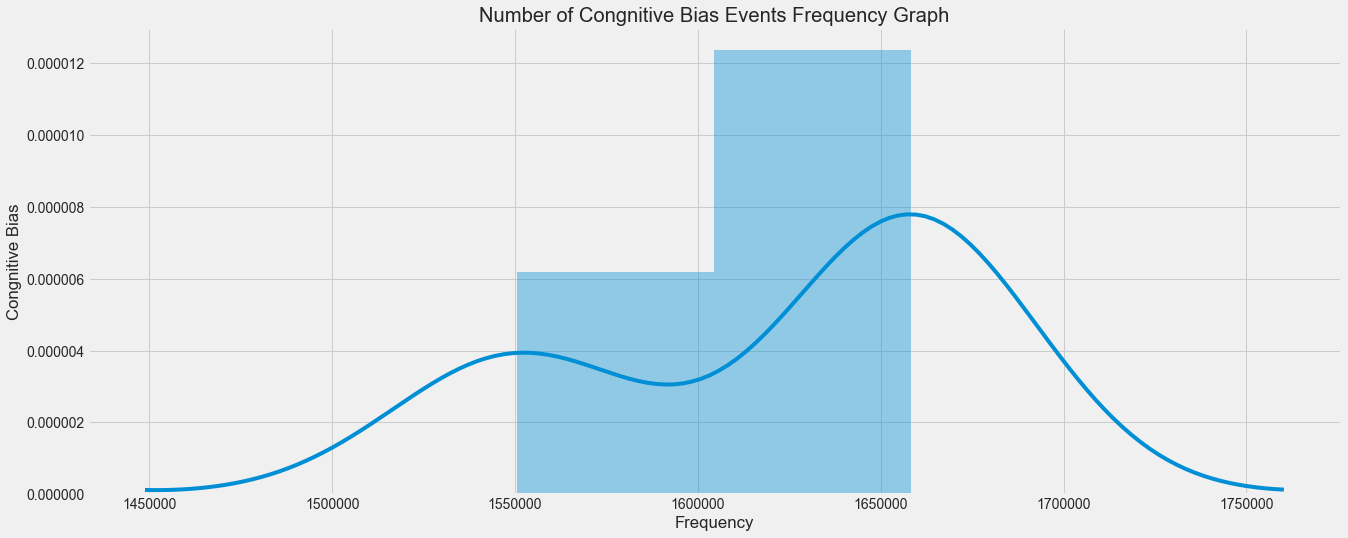

In [9]:
plt.figure(figsize = (20, 8))
sns.distplot(train['experiment'].value_counts(sort=True, ascending=True))
plt.xlabel("Frequency")
plt.ylabel("Congnitive Bias")
plt.title("Number of Congnitive Bias Events Frequency Graph")

Text(0.5,1,'Number of Congnitive Bias Events Frequency Graph')

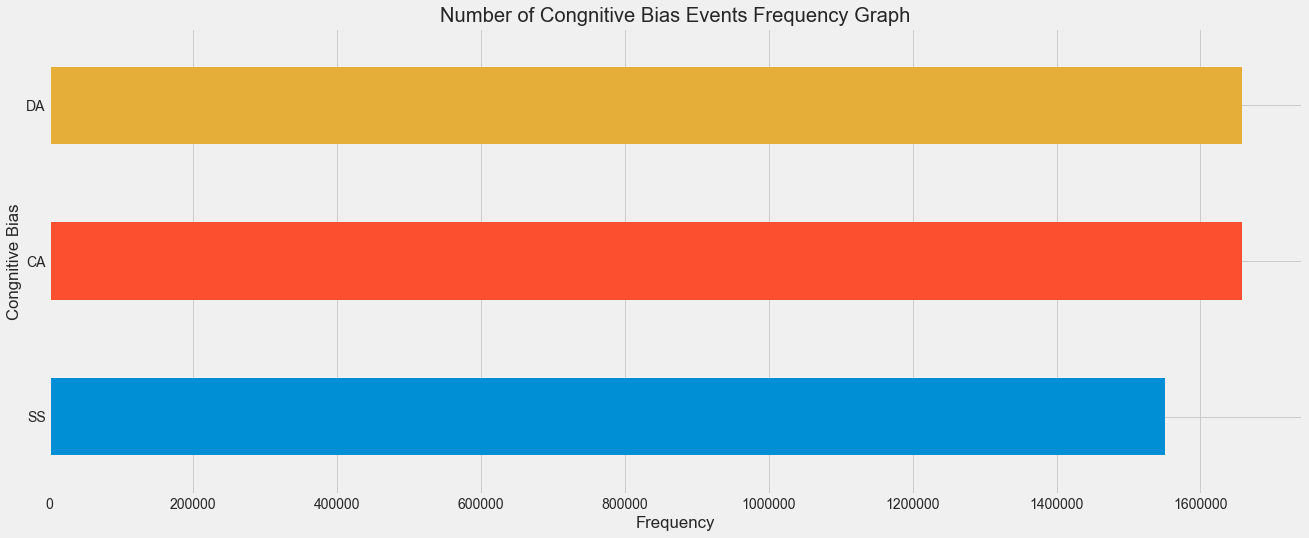

In [12]:
train['experiment'].value_counts(sort=True, ascending=True).plot(kind="barh", figsize = (20,8))
plt.xlabel("Frequency")
plt.ylabel("Congnitive Bias")
plt.title("Number of Congnitive Bias Events Frequency Graph")

Text(0.5,1,'Events by Time interval')

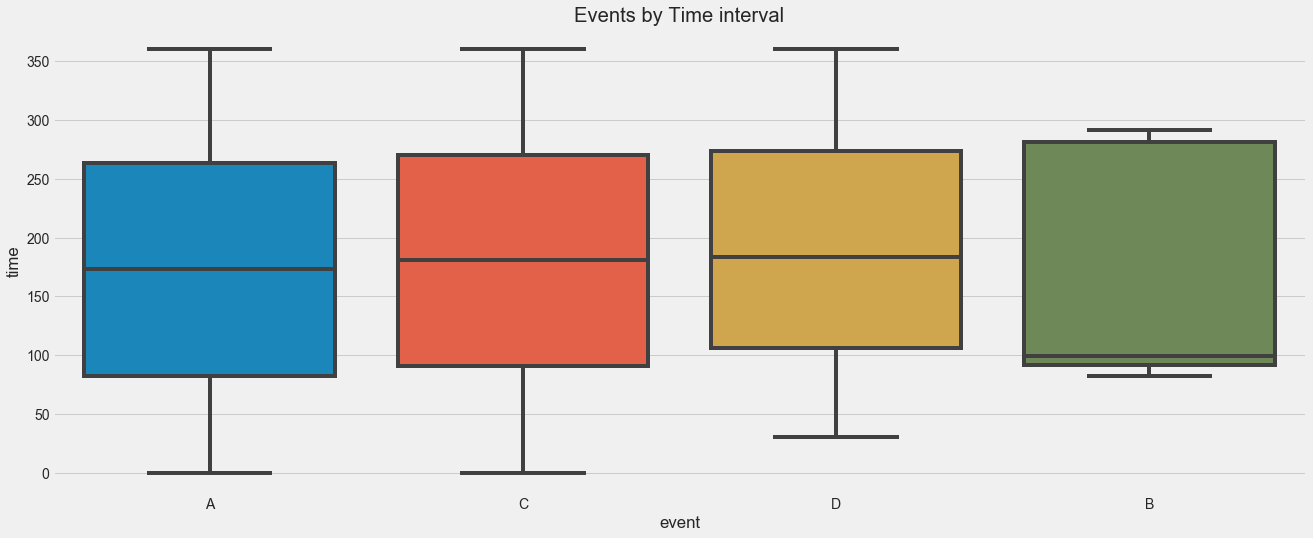

In [13]:
plt.figure(figsize=(20,8))
sns.boxplot(x = "event", y = "time", data=train);
plt.title("Events by Time interval")

Text(0.5,1,'Target Variable : Number of Events Occurences Frequency Graph')

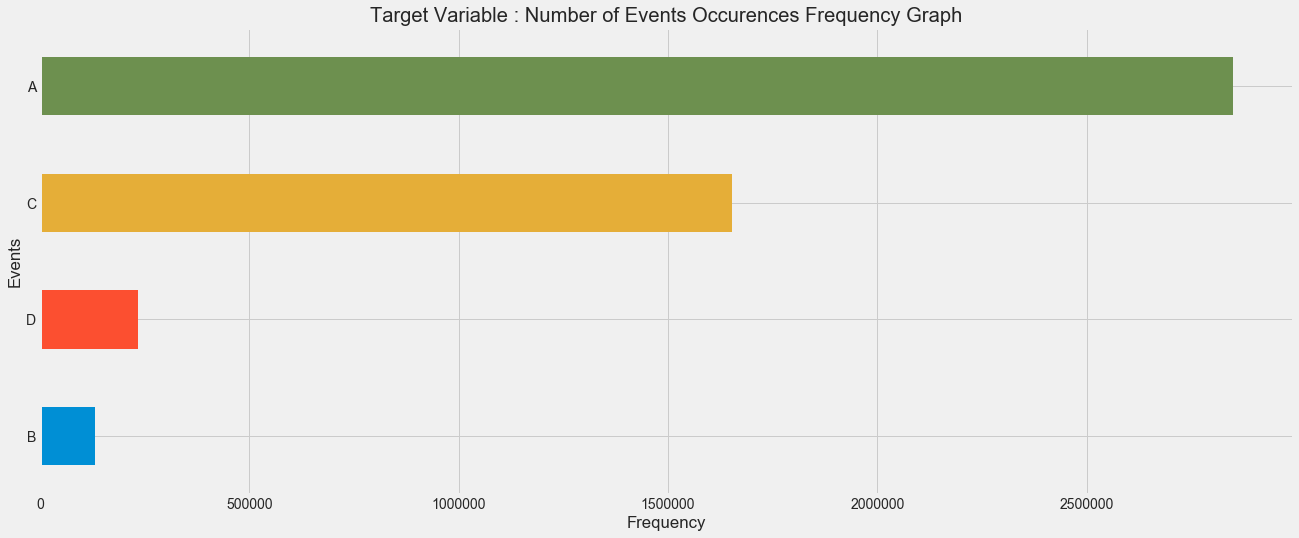

In [14]:
train['event'].value_counts(sort=True, ascending=True).plot(kind="barh", figsize = (20,8))
plt.xlabel("Frequency")
plt.ylabel("Events")
plt.title("Target Variable : Number of Events Occurences Frequency Graph")

seat,0,1
event,,
A,1424524,1424285
B,65293,65304
C,826401,826285
D,117721,117608


Text(0.5,1,'Frequency of Events per Seat')

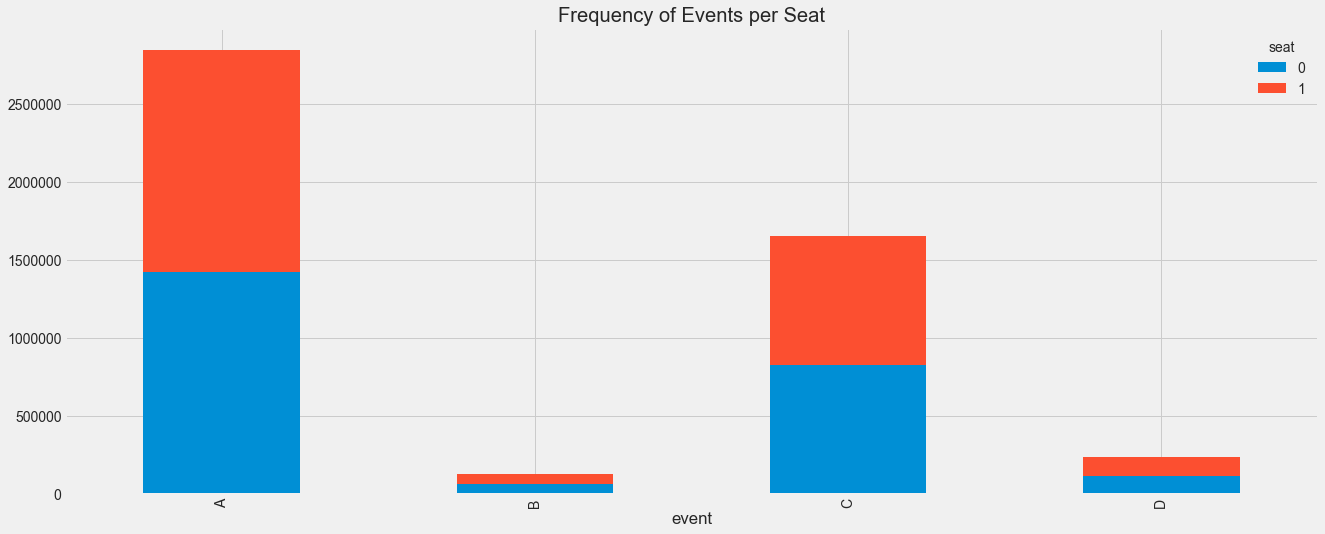

In [16]:
cm = sns.light_palette("orange", as_cmap=True)

cross_data = pd.crosstab(train['event'],train['seat'])
s = cross_data.style.background_gradient(cmap='viridis', low=.5, high=0).highlight_null('red')
display(s)
cross_data.plot(kind="bar", stacked = True, figsize = (20,8))
plt.title("Frequency of Events per Seat")

Observed table:
---------------
experiment       CA       DA       SS
event                                
A              5690  1423064  1420055
B                 0        0   130597
C           1652686        0        0
D                 0   235329        0
Statistics:
-----------
Chi2 = 5392299.747477, pval = 0.000000
Expected table:
---------------
[[970615.95333217 970625.90310906 907567.14355878]
 [ 44495.62313841  44496.07926271  41605.29759887]
 [563085.62541354 563091.39760008 526508.97698638]
 [ 80178.79811588  80179.62002814  74970.58185598]]


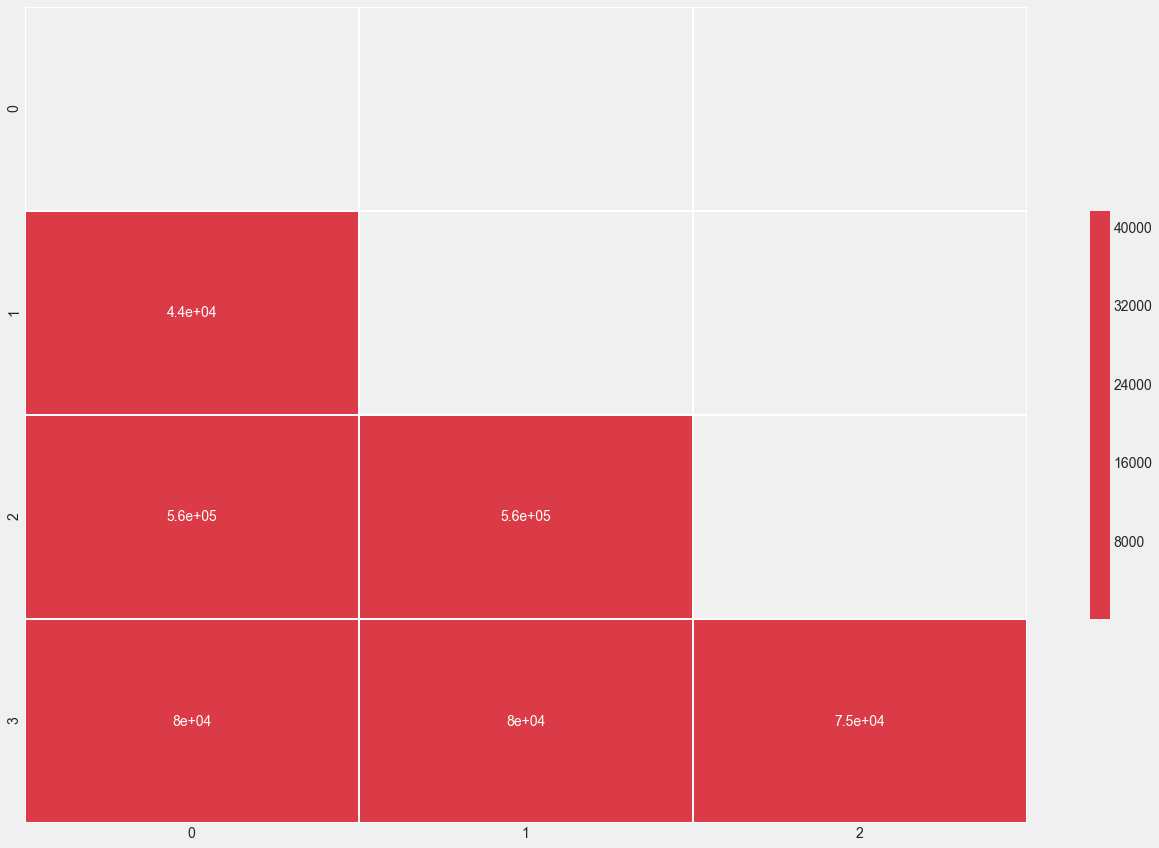

In [18]:
import scipy.stats as stats

crosstab = pd.crosstab(train['event'], train['experiment'], rownames=['event'], colnames=['experiment'])
print("Observed table:")
print("---------------")
print(crosstab)
chi2, pval, dof, expected = stats.chi2_contingency(crosstab)
print("Statistics:")
print("-----------")
print("Chi2 = %f, pval = %f" % (chi2, pval))
print("Expected table:")
print("---------------")
print(expected)

# Generate a mask for the upper triangle
mask = np.zeros_like(expected, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 14))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(expected , mask=mask, cmap=cmap, vmax=.3, center=0, annot= True,
            square=False, linewidths=.9, cbar_kws={"shrink": .5})

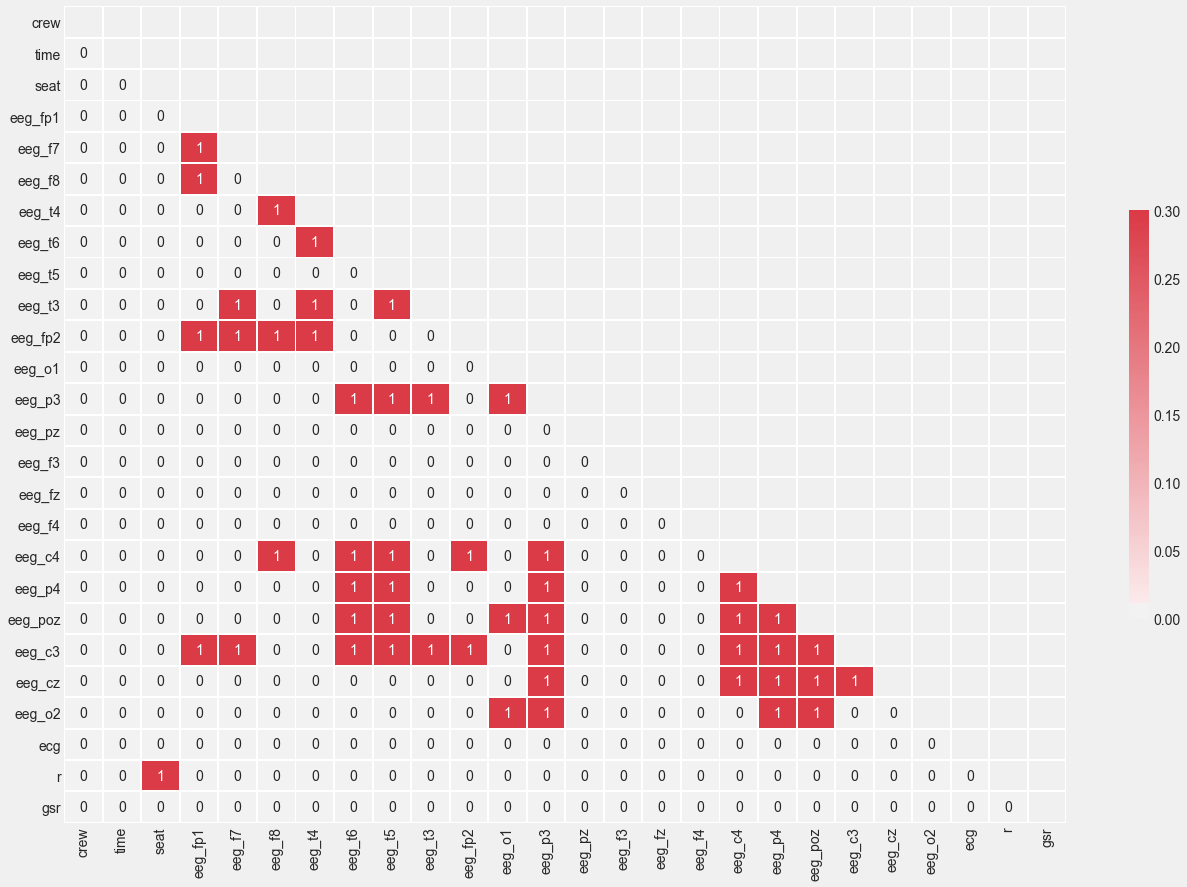

In [19]:
# Generate a mask for the upper triangle
corr = train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 14))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr > 0.5, mask=mask, cmap=cmap, vmax=.3, center=0, annot= True,
            square=False, linewidths=.9, cbar_kws={"shrink": .5})